In [1]:
import sys
from matplotlib import pyplot as plt
import numpy as np

# An example of a generator

We will demonstrate the use of generators, by modifying the hump function so that it returns a generator object instead of a complete time series. The two versions of the function are contained in an example module 'hump.py'. Open it up if you want to see their workings.

We begin by importing this module.

In [2]:
import hump
dir(hump)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'generate',
 'numpy',
 'series']

The `series` function returns a complete time series as we have seen before.

In [3]:
n = 6
y0 = 0.5
beta = 3.

hArray = hump.series(n, y0, beta)

print(type(hArray))
print(hArray)

<class 'numpy.ndarray'>
[0.5        0.75       0.5625     0.73828125 0.57966614 0.73095992]


The `generate` function takes the same arguments but returns a generator object.

In [4]:
hGen = hump.generate(n, y0, beta)

print(type(hGen))
print(hGen)

<class 'generator'>
<generator object generate at 0x7fa4c90cf7d8>


The generator object does not display for us its values when we print it out. This is because they have not been calculated yet. We can think of a generator approximately as a 'paused' function call. It is ready to generate its values one by one but only does so when we tell it to. Each time we get one of the values, the function call 'moves on' until the point that the next value is ready, and then waits again until we ask for that one.

Take a look inside the file we imported to see how the generator function works. In place of a `return` statement, the generator function has a `yield` statement. This marks the place at which the next value is calculated and returned. Each time we get one of the values, the function moves on as far as the next `yield`.

Iterating in a loop will cause the generator to generate its values, and the result is the same as iterating through a list or array.

In [5]:
for y in hGen:
    print(y)

0.5
0.75
0.5625
0.73828125
0.5796661376953125
0.7309599195141345


Generators are intended for single use. If we have generated all the values, then the generator has 'finished' and can't be iterated again, because the 'paused function' has moved on all the way to its end.

In [6]:
for y in hGen:
    print(y)
# no output

If we want to get the generator's values again, we need to create a new one.

In [7]:
hGen = hump.generate(n, y0, beta)

Both of these features, not displaying all values together and only iterating once, seem like disadvantages compared to a list or array. So what is the point of a generator? The advantages are somewhat 'behind the scenes'. Because a list or array stores all its values ready for repeated access, it tends to take up more space in our computer's memory. A generator stores only the algorithm for generating successive values, so it takes up an amount of memory that does not necessarily increase the more values we generate.

The `getsizeof` function from the `sys` module can tell us the size (in bytes) of a Python object in memory.

In [8]:
print(sys.getsizeof(hArray))
print(sys.getsizeof(hGen))

144
88


Note that the size of the array depends on how many values it contains. But the generator does not increase in size even if we want to generate many more values. This is because it does not contain the values, only instructions for generating them.

In [9]:
n = 9000

hArray = hump.series(n, y0, beta)
hGen = hump.generate(n, y0, beta)

print(sys.getsizeof(hArray))
print(sys.getsizeof(hGen))

72096
88


This feature of a generator is particularly useful if we do not know in advance how far through a series we want to iterate. If we are just searching for the first value that meets a certain criterion, the generator will only compute values up until the value we are searching for. With a list or array, we need first to compute all the values, then start searching through them.

Imagine we are searching in a time series for the first value within a certain distance of a target value. The plot below shows the region within which values satisfy the search criterion.

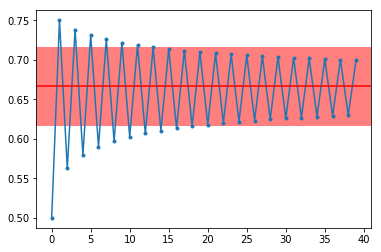

In [10]:
n = 40

hArray = hump.series(n, y0, beta)

target = 2./3
criterion = 0.05
targetRange = (target-criterion, target+criterion)

plt.plot(hArray, marker='.')
plt.axhline(target, color='red')
plt.axhspan(*targetRange, facecolor='red', alpha=0.5)
plt.show()

We can see that value 13 is the first that satisfies the search criterion. If we just want to find this out, we don't need all the values in the array.

In [11]:
np.where(np.abs(hArray - target) < criterion)[0]

array([13, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39])

Let's define a function for performing such a search. The function returns as soon as it finds the first acceptable value.

In [12]:
def find_first(series, target):
    """
    Find the position of the first value in a hump time series that is within a certain range.
    
    Arguments:
    series -- a hump time series (created by hump.series or hump.generate)
    target -- tuple of (min, max) specifying target range
    
    Returns:
    int index of first acceptable value in series, or None if no acceptable value is found
    """
    for i,y in enumerate(series):
        if target[0] < y < target[1]:
            return i

And let's test it using the example we plotted above.

In [13]:
print(find_first(hArray, targetRange))

13


Now we can see how the function performs when it has to search an unnecessarily long series for a value that occurs early on in the series. We can time how long the search takes when the series is an array compared to when it is a generator.

The IPython `%timeit` function times the execution of a Python statement.

In [14]:
n = 9000

%timeit find_first(hump.series(n, y0, beta), targetRange)

100 loops, best of 3: 4.79 ms per loop


In [15]:
%timeit find_first(hump.generate(n, y0, beta), targetRange)

100000 loops, best of 3: 2.78 µs per loop


Note that the result for the generator version is given in microseconds, whereas the result for the array version is in milliseconds.

So creating and interating through a generator can be a lot faster than doing the same for an array if there is a chance that the iteration will break off early.

But we shouldn't get carried away with novelty for the sake of it. If speed and memory usage is not a concern or if we will need to access values repeatedly or not in order, then a list or array can be more convenient to work with.